# 7. Gyakorlat: Mesterséges mélytanulás

---
## Könyvtárak

In [1]:
import os
import tarfile
import warnings
import itertools
import cv2 as cv
import numpy as np
from itertools import compress
import matplotlib.pyplot as plt
from PIL import Image, ImageFile
from sklearn.metrics import confusion_matrix

import torchvision
import torch.nn as nn
import torch.utils.data
import torch.nn.functional as fn
from torchvision import transforms
from alexnet_pytorch import AlexNet
from torchvision.datasets.utils import download_url

warnings.simplefilter(action='ignore')
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")
warnings.filterwarnings('ignore')
ImageFile.LOAD_TRUNCATED_IMAGES=True

---
## Adathalmaz

Using downloaded and verified file: ./imagenette-160.tgz
Számítóegység: cpu


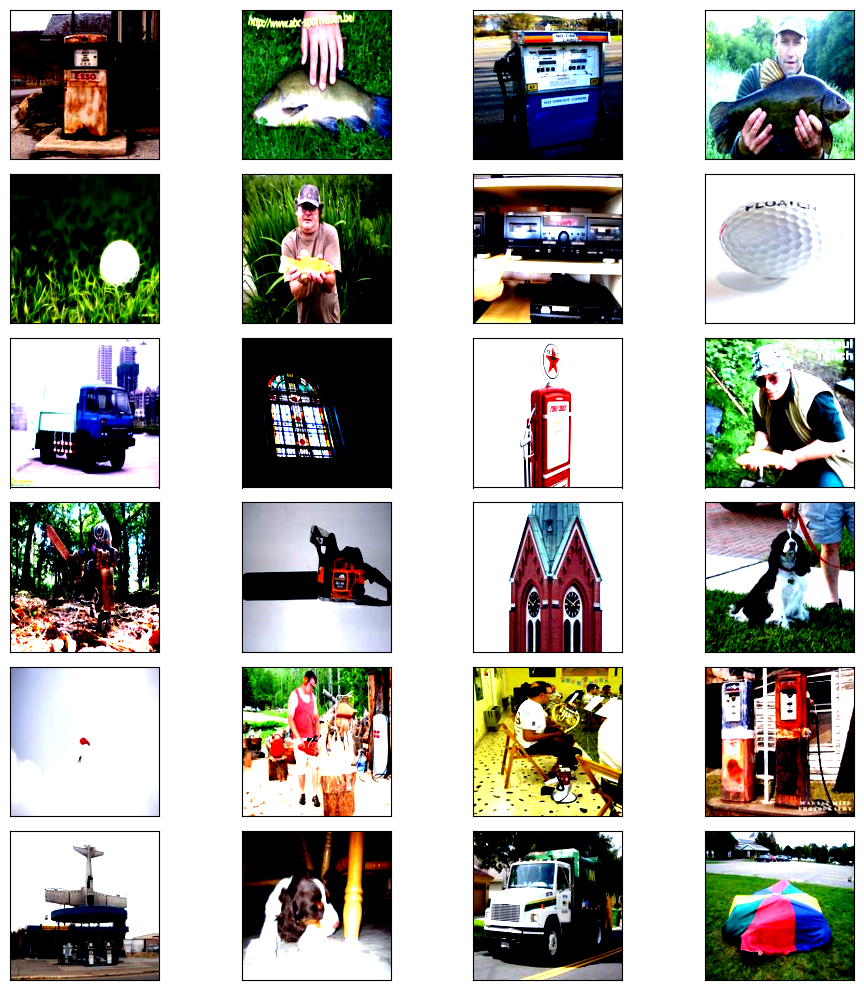

In [2]:
# Kép létezésének ellenőrzése
def check_image(path):
    try:
        Image.open(path)
        return True
    except BaseException as e:
        print(path, e)
        return False

# Transzformációs csővezeték a képek betöltéséhez
img_transforms = transforms.Compose([
    transforms.Resize((150, 150)),    
    transforms.ToTensor(),
    transforms.Normalize(  # Normalizálás az Imagenette átlaggal és szórással
        mean=[0.4914, 0.4822, 0.4465], 
        std=[0.2023, 0.1994, 0.2010]
    )
])

# Adathalmaz letöltése
dataset_url = "https://s3.amazonaws.com/fast-ai-imageclas/imagenette-160.tgz"
download_url(dataset_url, '.')

# Adathalmaz kicsomagolása
with tarfile.open('./imagenette-160.tgz', 'r:gz') as tar:
    tar.extractall(path='./data')

# Tanító és validációs adatok betöltése
train_data = torchvision.datasets.ImageFolder(
    root='./data/imagenette-160/train', 
    transform=img_transforms, 
    is_valid_file=check_image
)
val_data = torchvision.datasets.ImageFolder(
    root='./data/imagenette-160/val', 
    transform=img_transforms, 
    is_valid_file=check_image
)

# Tanító adatok szétválasztása tanító és teszt adatokra
train_size = int(len(train_data) * 0.7)
test_size = len(train_data) - train_size
train_set, test_set = torch.utils.data.random_split(train_data, [train_size, test_size])

# Adatbetöltő objektumok inicializálása
batch_size = 24
train_data_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size)
val_data_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size) 
test_data_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size) 

# Számítóegység átállítása nvidia GPU-ra, ha létezik
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f'Számítóegység: {device}')

# Adatbetöltők tesztelése
def display_img(param_img, show=True):
    param_img = np.clip(param_img / 2 + 0.5, 0, 1)  # Denormalizálás
    npimg = param_img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), interpolation='none')
    if show:
        plt.show()

# Képek ábrázolása egy matplotlib hálón
def img_grid(param_img):
    plt.figure(figsize=(10, 10))
    for x in range(0, 24):
        plt.subplot(6, 4, x + 1)
        grid_data = param_img[x]
        display_img(grid_data, show=False)
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout()

image, label = next(iter(test_data_loader))
img_grid(image)

---
## Architektúra

In [3]:
# Architektúra betöltése
alexnet = AlexNet.from_pretrained('alexnet', num_classes = 10)
alexnet.to(device)
alexnet.eval()

# Paraméterek fagyasztása (taníthatatlanná tétele)
for param in alexnet.parameters():
    param.requires_grad = False

# Az utolsó hálózati réteg hozzáadása és ezzel taníthatóvá állítása
alexnet.classifier[6] = nn.Linear(4096, 10)
alexnet = alexnet.to(device)

# Tanítható paraméterek kigyűjtése egy listába
params_to_learn = []
for name, param in alexnet.named_parameters():
    if param.requires_grad:
        params_to_learn.append(param)

# Optimalizáló algoritmus definiálása és paraméterezése
optimizer = torch.optim.RMSprop(
    params_to_learn, 
    lr = 0.00001,
    alpha = 0.99,
    eps = 1e-08,
    weight_decay = 0,
    momentum = 0.9,
    centered = False
)

# Költségfüggvény - mivel osztályozásról van szó - keresztentrópia
loss_fn = torch.nn.CrossEntropyLoss()

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /home/daniel/.var/app/com.jetbrains.PyCharm-Professional/cache/torch/hub/checkpoints/alexnet-owt-4df8aa71.pth
100.0%


Loaded pretrained weights for alexnet


---
## Tanítás

In [5]:
best_model = alexnet
best_epoch = -1
num_epochs = 30
min_val_error = float('inf')
error_going_up = 0
history = {
    'train_loss': [], 
    'train_acc': [], 
    'valid_loss': [], 
    'valid_acc': []
}

for epoch in range(num_epochs):  # Iteráció minden tanítási epochra
    # Tanítási fázis
    alexnet.train()  # Hálózat tanítási módba kapcsolása
    train_loss = 0.0  # Költség nullára állítása
    train_corrects = 0  # Helyes predikciók számának nullára állítása
    for idx, (inputs, labels) in enumerate(train_data_loader):  # Iteráció az adatbetöltőn
        optimizer.zero_grad()  # Gradiensek kinullázása
        inputs = inputs.to(device)  # Input képek betöltése a számítási kapacitásra
        labels = labels.to(device)  # Címkék betöltése a számítási kapacitásra
        
        output = alexnet(inputs)  # Képek végigáramoltatása a hálózaton
        loss = loss_fn(output, labels)  # Költség kiszámítása a becsült és valós címkék alapján
        loss.backward()  # Költség visszaáramoltatása a hálózatba
        optimizer.step()  # Lépés az optimalizálóval a költségnek megfelelően

        _, preds = torch.max(output, 1)  # Predikciók kiválasztása a softmax rétegből
        train_loss += loss.item() * inputs.size(0)  # Költség hozzáadása a tanítási költséghez
        train_corrects += np.sum(preds == labels.data)  # Helyes predikciók számának növelése

    train_loss = train_loss / len(train_data_loader.dataset)  # Tanítási költség
    train_acc = train_corrects.double() / len(train_data_loader.dataset)  # Tanítási pontosság
    
    history['train_loss'].append(train_loss)  # Hozzáfűzés a követési struktúrához
    history['train_acc'].append(train_acc)  # Hozzáfűzés a követési struktúrához

    # Validációs fázis
    alexnet.eval()  # Hálózat kiértékelési módba kapcsolása
    running_loss = 0.0  # Költség nullára állítása
    running_corrects = 0  # Helyes predikciók nullára állítása
    for inputs, labels in val_data_loader:  # Iteráció az adatbetöltőn
        inputs = inputs.to(device)  # Input képek betöltése a számítási kapacitásra
        labels = labels.to(device)  # Címkék betöltése a számítási kapacitásra
        
        with torch.set_grad_enabled(False):  # Gradiens számítások kikapcsolása
            output = alexnet(inputs)  # Inputok végigáramoltatása a hálózaton
            loss = loss_fn(output, labels)  # Költség számítása
            
            _, preds = torch.max(output, 1)  # Predikciók előállítása a softmax max. értékeinek kiválasztásával
            running_loss += loss.item() * inputs.size(0)  # Költség hozzáadása a teljes költséghez
            running_corrects += np.sum(preds == labels.data)  # Helyes predikciók számának növelése
            
    epoch_loss = running_loss / len(val_data_loader.dataset)  # Iterációs költség frissítése
    epoch_acc = running_corrects.double() / len(val_data_loader.dataset)  # Iterációs pontosság frissítése
    
    history['valid_loss'].append(epoch_loss)  # Hozzáfűzés a követési struktúrához
    history['valid_acc'].append(epoch_acc)  # Hozzáfűzés a követési struktúrához

    # Early stopping implementáció
    if epoch_loss <= min_val_error:
        min_val_error = epoch_loss
        error_going_up = 0
        best_model = alexnet
        best_epoch = epoch
    else:
        error_going_up += 1
        if error_going_up == 5:
            print(f'Tanítás megállítva idő előtti kiszállással {epoch} iterációban. Legjobb iteráció: {best_epoch}')
            break 

    print('{}. Költség: {:.4f} Pontosság: {:.4f}'.format(epoch, epoch_loss, epoch_acc))

[W NNPACK.cpp:64] Could not initialize NNPACK! Reason: Unsupported hardware.


0. Költség: 0.3255 Pontosság: 0.9160
1. Költség: 0.2929 Pontosság: 0.9180
2. Költség: 0.2743 Pontosság: 0.9260
3. Költség: 0.2734 Pontosság: 0.9200
4. Költség: 0.2702 Pontosság: 0.9300
5. Költség: 0.2657 Pontosság: 0.9280
6. Költség: 0.2690 Pontosság: 0.9300
7. Költség: 0.2716 Pontosság: 0.9260
8. Költség: 0.2779 Pontosság: 0.9280
9. Költség: 0.2836 Pontosság: 0.9260
Tanítás megállítva idő előtti kiszállással 10 iterációban. Legjobb iteráció: 5


### Pontosságok és költségek vizsgálata

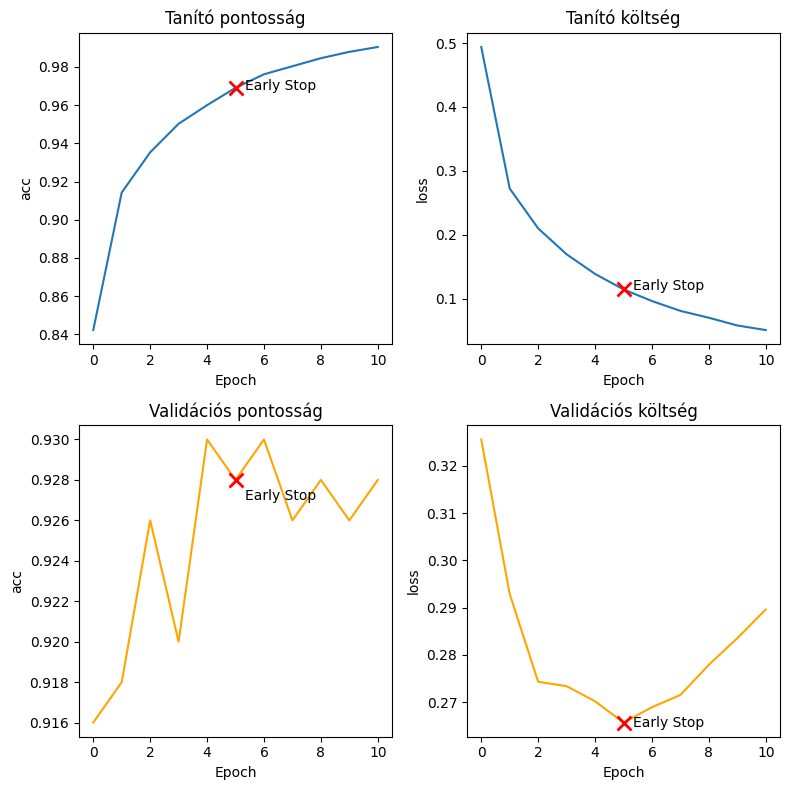

In [6]:
titles = {
    'train_acc': 'Tanító pontosság', 
    'train_loss': 'Tanító költség', 
    'valid_acc': 'Validációs pontosság', 
    'valid_loss': 'Validációs költség'
}

plt.figure(figsize=(8, 8))
for idx, name in enumerate(['train_acc', 'train_loss', 'valid_acc', 'valid_loss']):
    plt.subplot(2, 2, idx + 1)

    if name.split('_')[0] == 'valid':
        plt.plot(history[name], color='orange')
    else:
        plt.plot(history[name])

    plt.plot(best_epoch, history[name][best_epoch], color='red', marker='x', markersize=10, markeredgewidth='2')
    plt.annotate('Early Stop', xy=(best_epoch+0.35, history[name][best_epoch]-0.001))
    plt.title(titles[name])
    plt.ylabel(name.split('_')[1])
    plt.xlabel('Epoch')
plt.tight_layout()
plt.show()

---
## Modell kiértékelése
### Legjobb modell futtatása a teszt adathalmazon

In [7]:
# Predikciók címkéinek felvitele
# labels = ['Fish', 'Dog', 'Casette player', 'Chainsaw', 'Church', 'Horn', 'Truck', 'Gaspump', 'Golfball', 'Parachute']
labels = ['Hal', 'Kutya', 'Magnó', 'Láncfűrész', 'Templom', 'Kürt', 'Kamion', 'Töltőállomás', 'Golflabda', 'Ejtőernyő']

y_pred, y_true, y_inst, y_prob = [], [], [], []

alexnet.eval()
num_correct = 0 
num_examples = 0
valid_loss = 0.0

for batch in test_data_loader:
    inputs, targets = batch
    inputs = inputs.to(device)
    output = alexnet(inputs)
    targets = targets.to(device)
    _, preds = torch.max(output, 1)
    y_prob.extend(output)
    y_inst.extend(inputs)
    y_pred.extend([labels[x] for x in preds])
    y_true.extend([labels[x] for x in targets])
    loss = loss_fn(output,targets) 
    valid_loss += loss.data.item() * inputs.size(0)
    correct = torch.eq(torch.max(fn.softmax(output, dim=1), dim=1)[1],targets)
    num_correct += torch.sum(correct).item()
    num_examples += correct.shape[0]

valid_loss /= len(test_data_loader.dataset)
print(f'Teszt futtatás: \nKöltség = {round(valid_loss, 2)}, Pontosság = {round(num_correct / num_examples, 2)}')

Teszt futtatás: 
Költség = 0.34, Pontosság = 0.9


### Konfúziós mátrix

Text(0.5, -31.7839510252674, 'Becsült osztály')

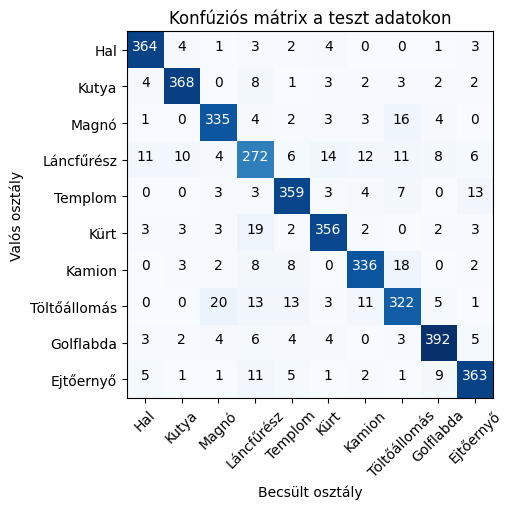

In [8]:
normalize = False
cmap = plt.cm.get_cmap("Blues")
cm = confusion_matrix(y_true, y_pred, labels=labels) 

plt.figure(figsize=(5, 5))
plt.imshow(cm, interpolation='nearest', cmap=cmap)
plt.title('Konfúziós mátrix a teszt adatokon')
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels)

if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
thresh = cm.max() / 2
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment='center', color='white' if cm[i, j] > thresh else 'black')
    
plt.tight_layout()
plt.ylabel('Valós osztály')
plt.xlabel('Becsült osztály')

### Konfúziós mátrix normlizálása

<Figure size 1500x1500 with 0 Axes>

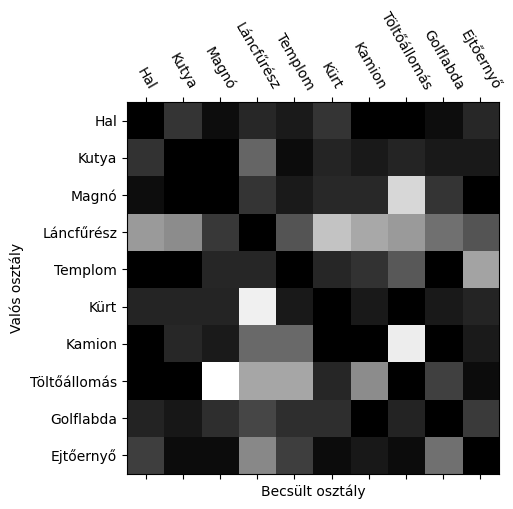

In [9]:
row_sums = cm.sum(axis=1, keepdims=True)
norm_conf_mx = cm / row_sums
np.fill_diagonal(norm_conf_mx, 0)

plt.figure(figsize=(15,15))
plt.matshow(norm_conf_mx, cmap=plt.cm.get_cmap("gray"))
plt.ylabel('Valós osztály')
plt.xlabel('Becsült osztály')
plt.xticks(range(10), labels=labels, rotation=300)
plt.yticks(range(10), labels=labels)
plt.show()

### Predikciók demonstrálása

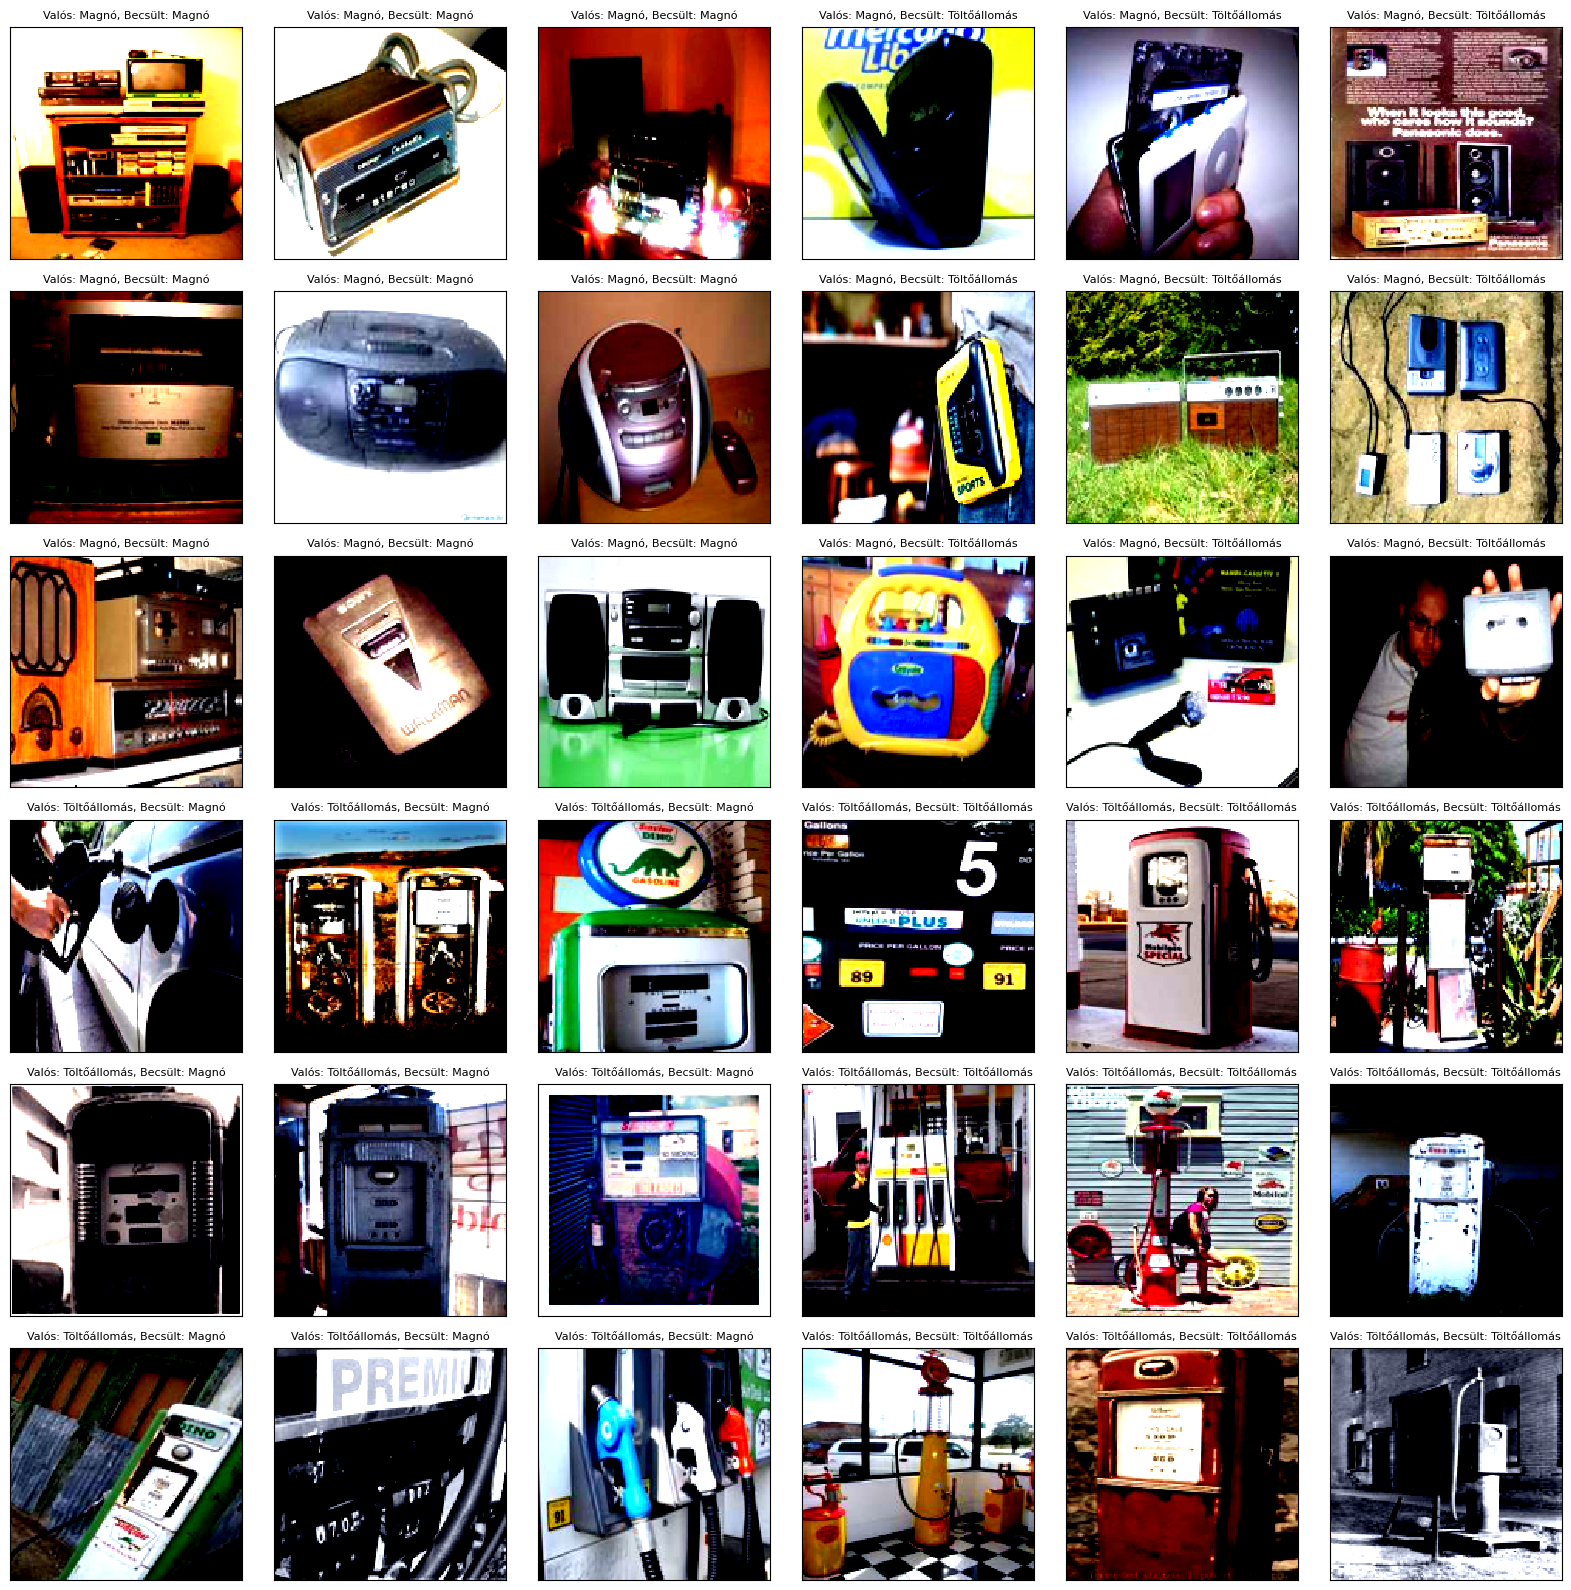

In [10]:
def get_quadrant(q):
    r = q % 6
    b = 3
    c = 18
    if (r > 0) & (r <= b) & (q / c <= 1):
        return 0
    elif ((r == 0) or (r > b)) & (q / c <= 1):
        return 1    
    elif (r > 0) & (r <= b) & (q / c > 1):
        return 2
    elif ((r == 0) or (r > b)) & (q / c > 1):
        return 3


def plot_images(param_quads, param_titles, a = 6, b = 6):
    counts = [0, 0, 0, 0]
    plt.figure(figsize=(16, 16))
    for x in range(1, a * b + 1):
        plt.subplot(a, b, x)
        curr_iter = get_quadrant(x)
        curr_quad_data = param_quads[curr_iter]

        if counts[curr_iter] == len(curr_quad_data):
            plt.text(0.5, 0.5, 'Nem található kép.', horizontalalignment='center', verticalalignment='center')
            continue

        curr_count = counts[curr_iter]
        grid_data = curr_quad_data[curr_count]
        counts[curr_iter] += 1 
        display_img(grid_data, show=False)
        plt.xticks([])
        plt.yticks([])
        plt.gca().set_title(param_titles[curr_iter], size=8)
    plt.tight_layout()

filt_conf = lambda param_cl_a, param_cl_b, param_y_true, param_y_pred: [
    True if x[0] == param_cl_a and x[1] == param_cl_b else False for x in zip(param_y_true, param_y_pred)
]
filt_list = lambda param_y_inst, filt_config: list(compress(param_y_inst, filt_config))

# Képek mutatása a két leginkább összetévesztett osztályból
cl_a = 'Magnó'
cl_b = 'Töltőállomás'

quads = [
    filt_list(y_inst, filt_conf(cl_a, cl_a)),  # Valós: magnó; Becsült: magnó
    filt_list(y_inst, filt_conf(cl_a, cl_b)),  # Valós: magnó; Becsült: töltőállomás
    filt_list(y_inst, filt_conf(cl_b, cl_a)),  # Valós: töltőállomás; Becsült: magnó
    filt_list(y_inst, filt_conf(cl_b, cl_b)),  # Valós: töltőállomás; Becsült: töltőállomás
]  

titles = [
    f'Valós: {cl_a}, Becsült: {cl_a}',
    f'Valós: {cl_a}, Becsült: {cl_b}',
    f'Valós: {cl_b}, Becsült: {cl_a}',
    f'Valós: {cl_b}, Becsült: {cl_b}',
]

plot_images(quads, titles)

### Legnagyobb hibával osztályozott egyedek mutatása

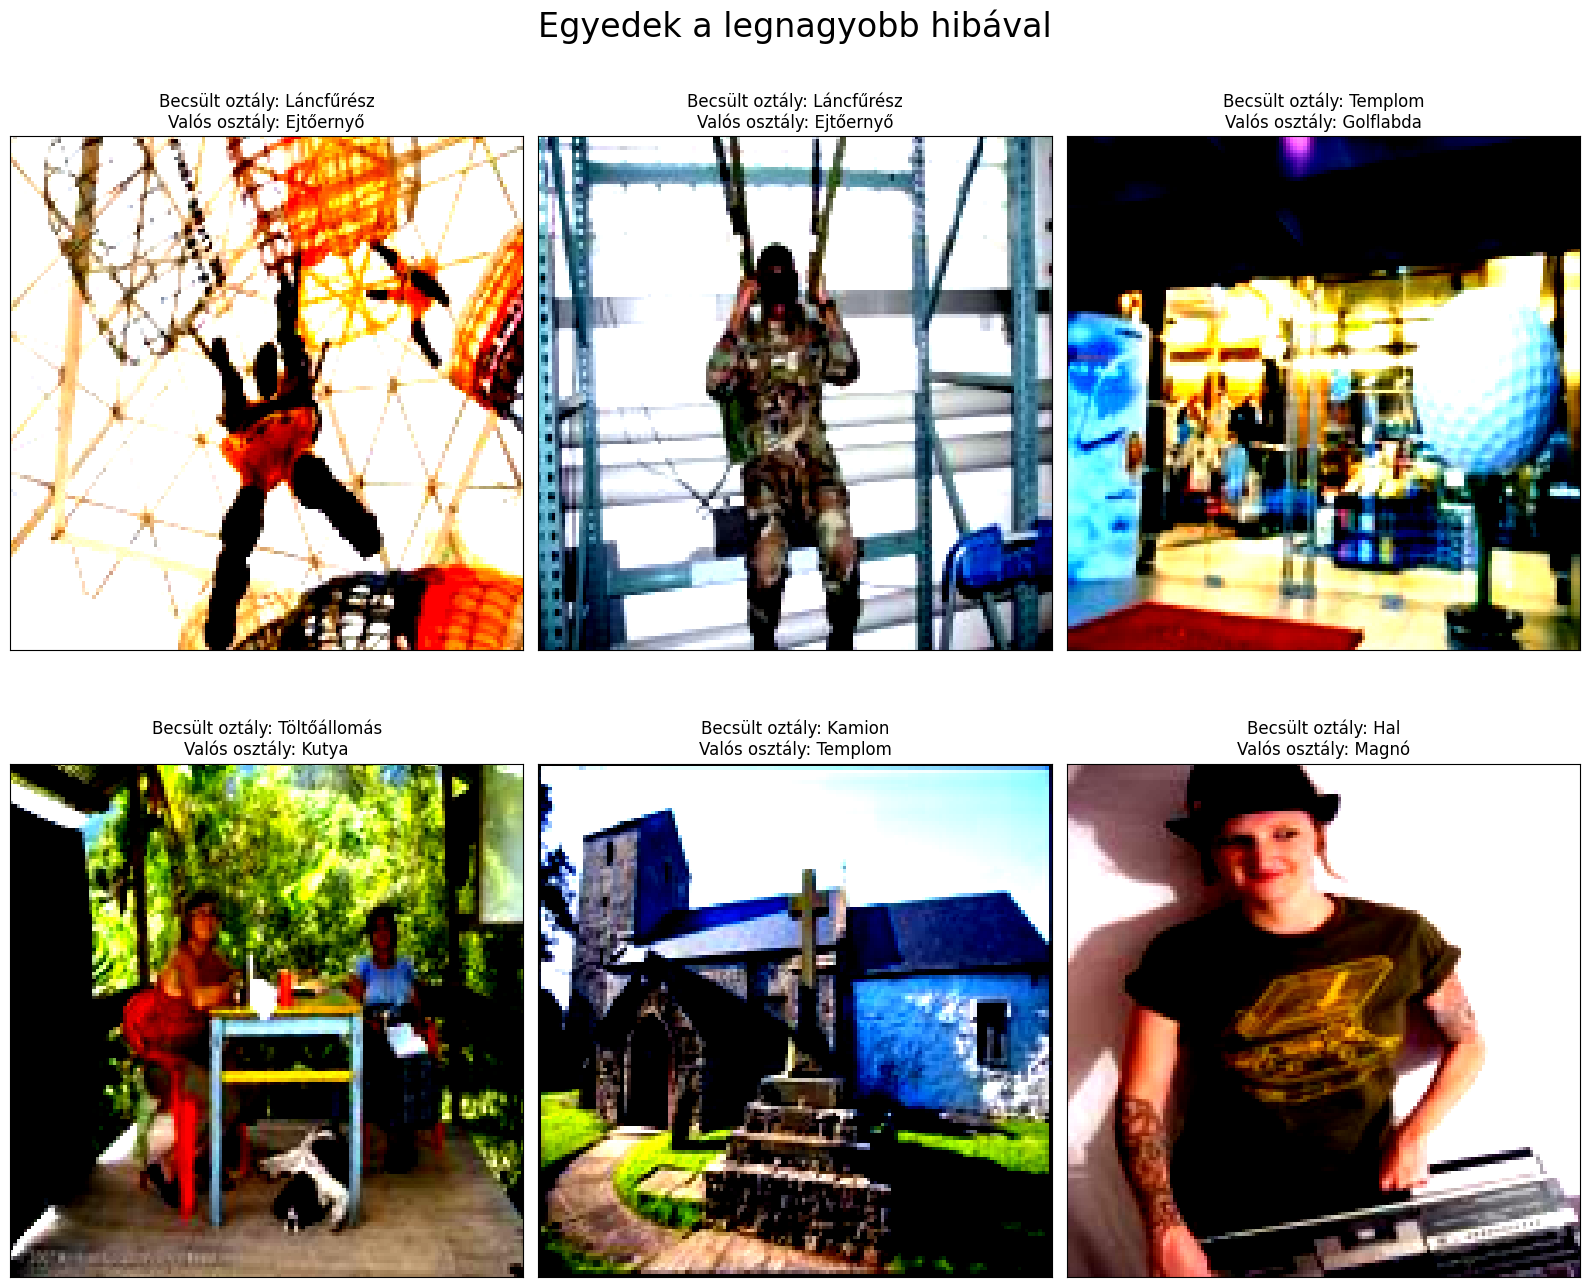

In [11]:
# Hibás esetek mutatására függvények
def get_ind(inst):
    for x in range(len(labels)):
        if labels[x] == inst:
            return x


def display_errors(errors_index, img_errors, pred_errors, obs_errors):
    n, nrows, ncols = 0, 2, 3
    plt.figure(figsize=(16, 14))
    plt.suptitle('Egyedek a legnagyobb hibával', size=24)
    for x in range(1, nrows * ncols + 1):
        plt.subplot(nrows, ncols, x)
        error = errors_index[n]
        display_img(img_errors[error], show=False)
        plt.gca().set_title("Becsült oztály: {}\nValós osztály: {}".format(pred_errors[error], labels[obs_errors[error]]), size=12)
        plt.xticks([])
        plt.yticks([])
        n += 1
    plt.tight_layout()
    plt.show()


# Egyedekhez tartozóan hiba kiszámítása és ábrázolása
errors = [x!=y for x,y in zip(y_true, y_pred)]

y_pred_classes_errors = filt_list(y_pred, errors)
y_prob_errors = [[float(y) for y in x] for x in filt_list(y_prob, errors)]
y_true_errors = [get_ind(x) for x in filt_list(y_true, errors)] 
x_val_error = filt_list(y_inst, errors)

Y_pred_errors_prob = [float(max(x)) for x in y_prob_errors] 
true_prob_errors = np.diagonal(np.take(y_prob_errors, y_true_errors, axis=1))
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

most_important_errors = sorted_dela_errors[-6:]
display_errors(most_important_errors, x_val_error, y_pred_classes_errors, y_true_errors)

---
## Aktivációk

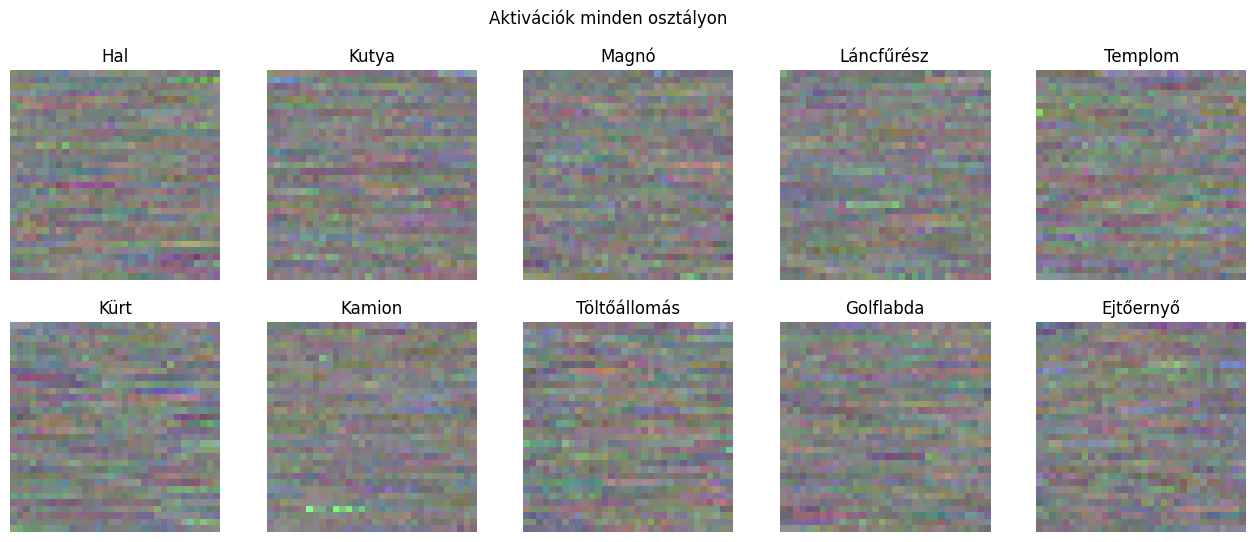

In [12]:
# Aktivációk vizualizálása
w = best_model.features[10].weight.detach().cpu().numpy()
buff = int(w.size / 32 / 32 / 3)
w = w.reshape(buff, 3, 32, 32).transpose(0, 2, 3, 1)
w_min, w_max = np.min(w), np.max(w)
classes = labels

plt.figure(figsize=(16,6))
plt.suptitle('Aktivációk minden osztályon')
for i in range(10):
  plt.subplot(2, 5, i + 1)
  wimg = 255.0 * (w[i].squeeze() - w_min) / (w_max - w_min)
  plt.imshow(wimg.astype('uint8'))
  plt.axis('off')
  plt.title(classes[i])

### Konvolúciós rétegek és súlyaik

In [13]:
# Konvolúciós rétegek és súlyaik lekérdezése
counter = 0 
conv_layers = [] 
model_weights = [] 
model_children = [x for x in [x for x in best_model.children()][0]]

for i in range(len(model_children)):
    if type(model_children[i]) == nn.Conv2d:
        counter += 1
        model_weights.append(model_children[i].weight)
        conv_layers.append(model_children[i])
    elif type(model_children[i]) == nn.Sequential:
        for j in range(len(model_children[i])):
            for child in model_children[i][j].children():
                if type(child) == nn.Conv2d:
                    counter += 1
                    model_weights.append(child.weight)
                    conv_layers.append(child)
print(f"Összes konvolúciós réteg: {counter}")

Összes konvolúciós réteg: 5


### Konvolúciós szűrők súlyainak vizualizálása

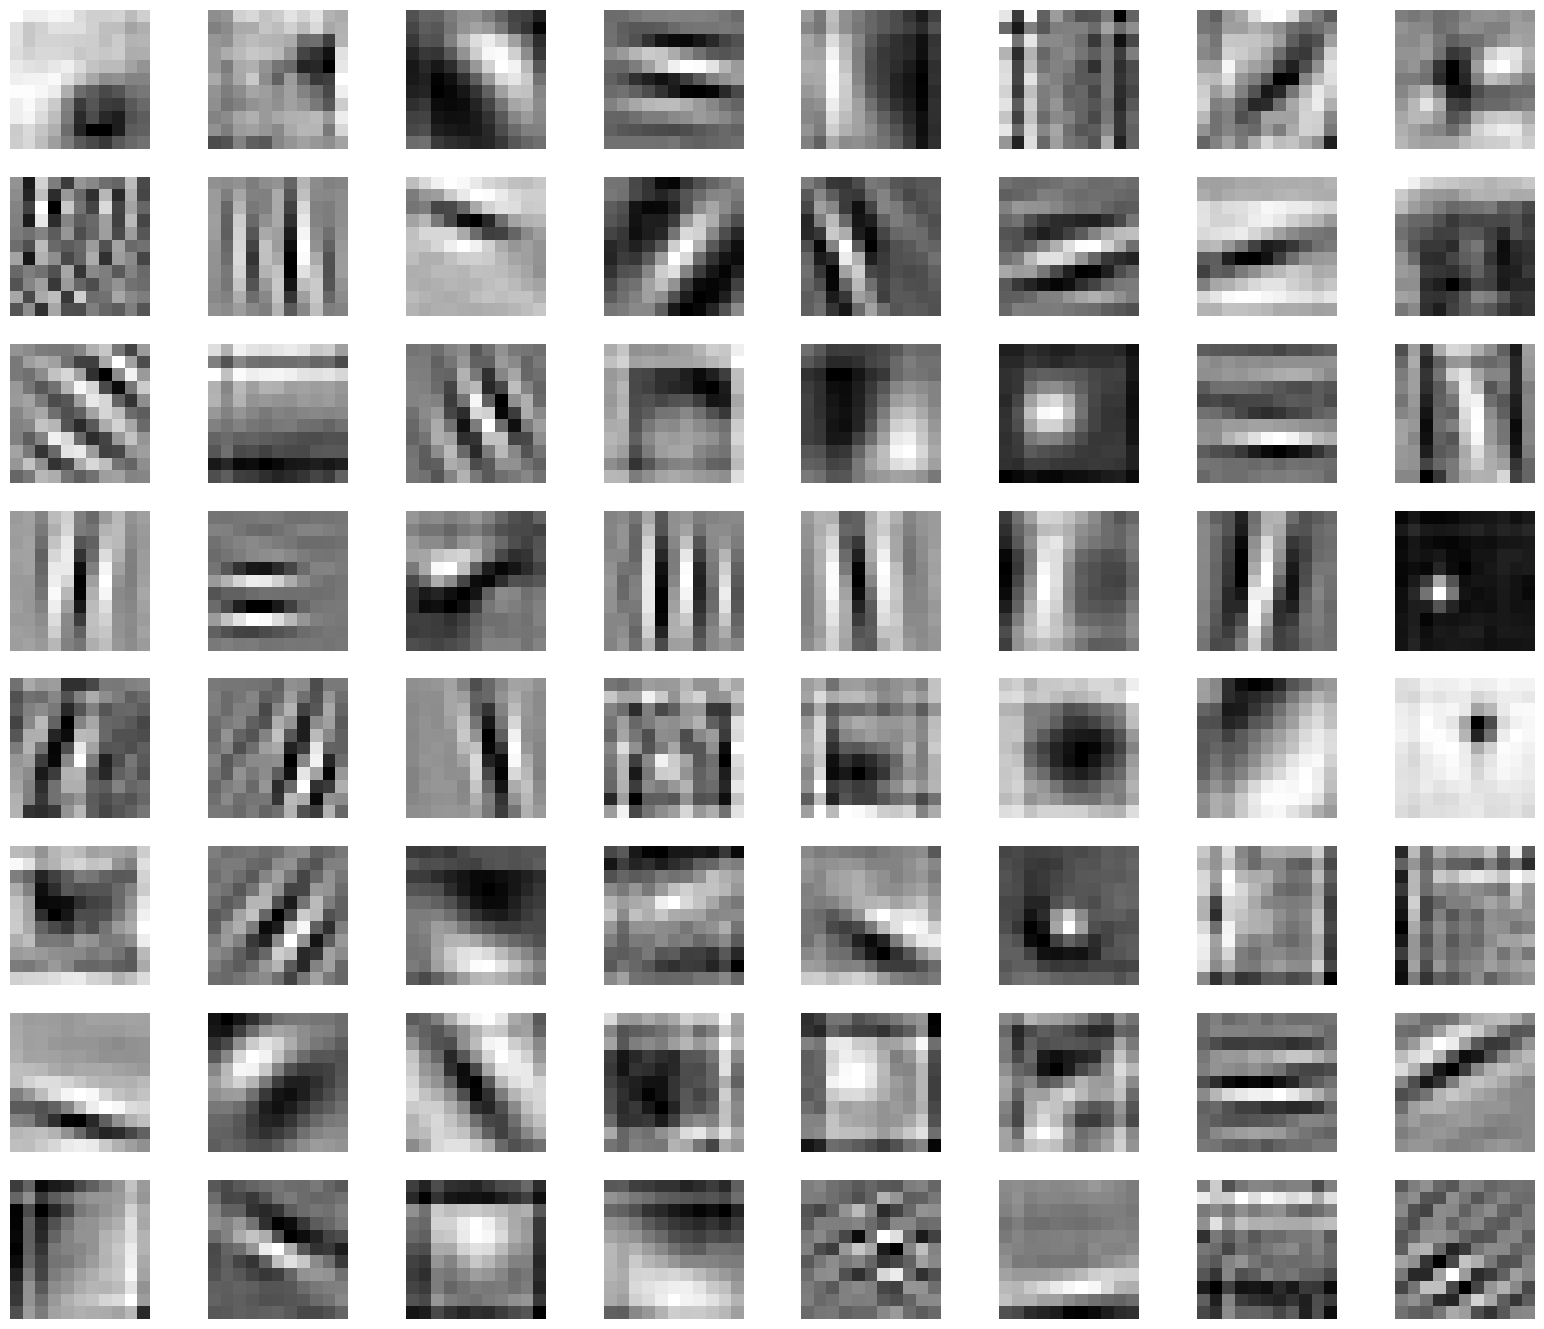

In [14]:
plt.figure(figsize=(20, 17))
for i, flt in enumerate(model_weights[0]):
    plt.subplot(8, 8, i + 1) 
    plt.imshow(flt[0, :, :].detach(), cmap='gray')
    plt.axis('off')
plt.show()

### Konvolúciós szűrők tesztelése egy választott képen

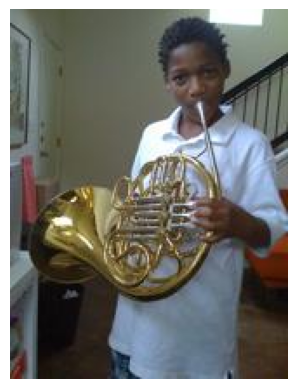

torch.Size([3, 150, 150])
torch.Size([1, 3, 150, 150])


In [15]:
# Kép beolvasása
train_folder = './data/imagenette-160/train/n03394916'
image_path = os.path.join(train_folder, np.random.choice(os.listdir(train_folder)))  # Véletlen kép választása az adathalmazból
img = cv.imread(image_path)

# Kép kirajzolása
img = img[:, :, ::-1]
plt.imshow(img)
plt.axis('off')
plt.show()

# Kép transzformálása
img = np.array(img)
vis_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((150, 150)),
    transforms.ToTensor(),]
)
img = vis_transform(img)
print(img.size())
img = img.unsqueeze(0)
print(img.size())

torch.Size([64, 36, 36])
torch.Size([192, 36, 36])
torch.Size([384, 36, 36])
torch.Size([256, 36, 36])
torch.Size([256, 36, 36])


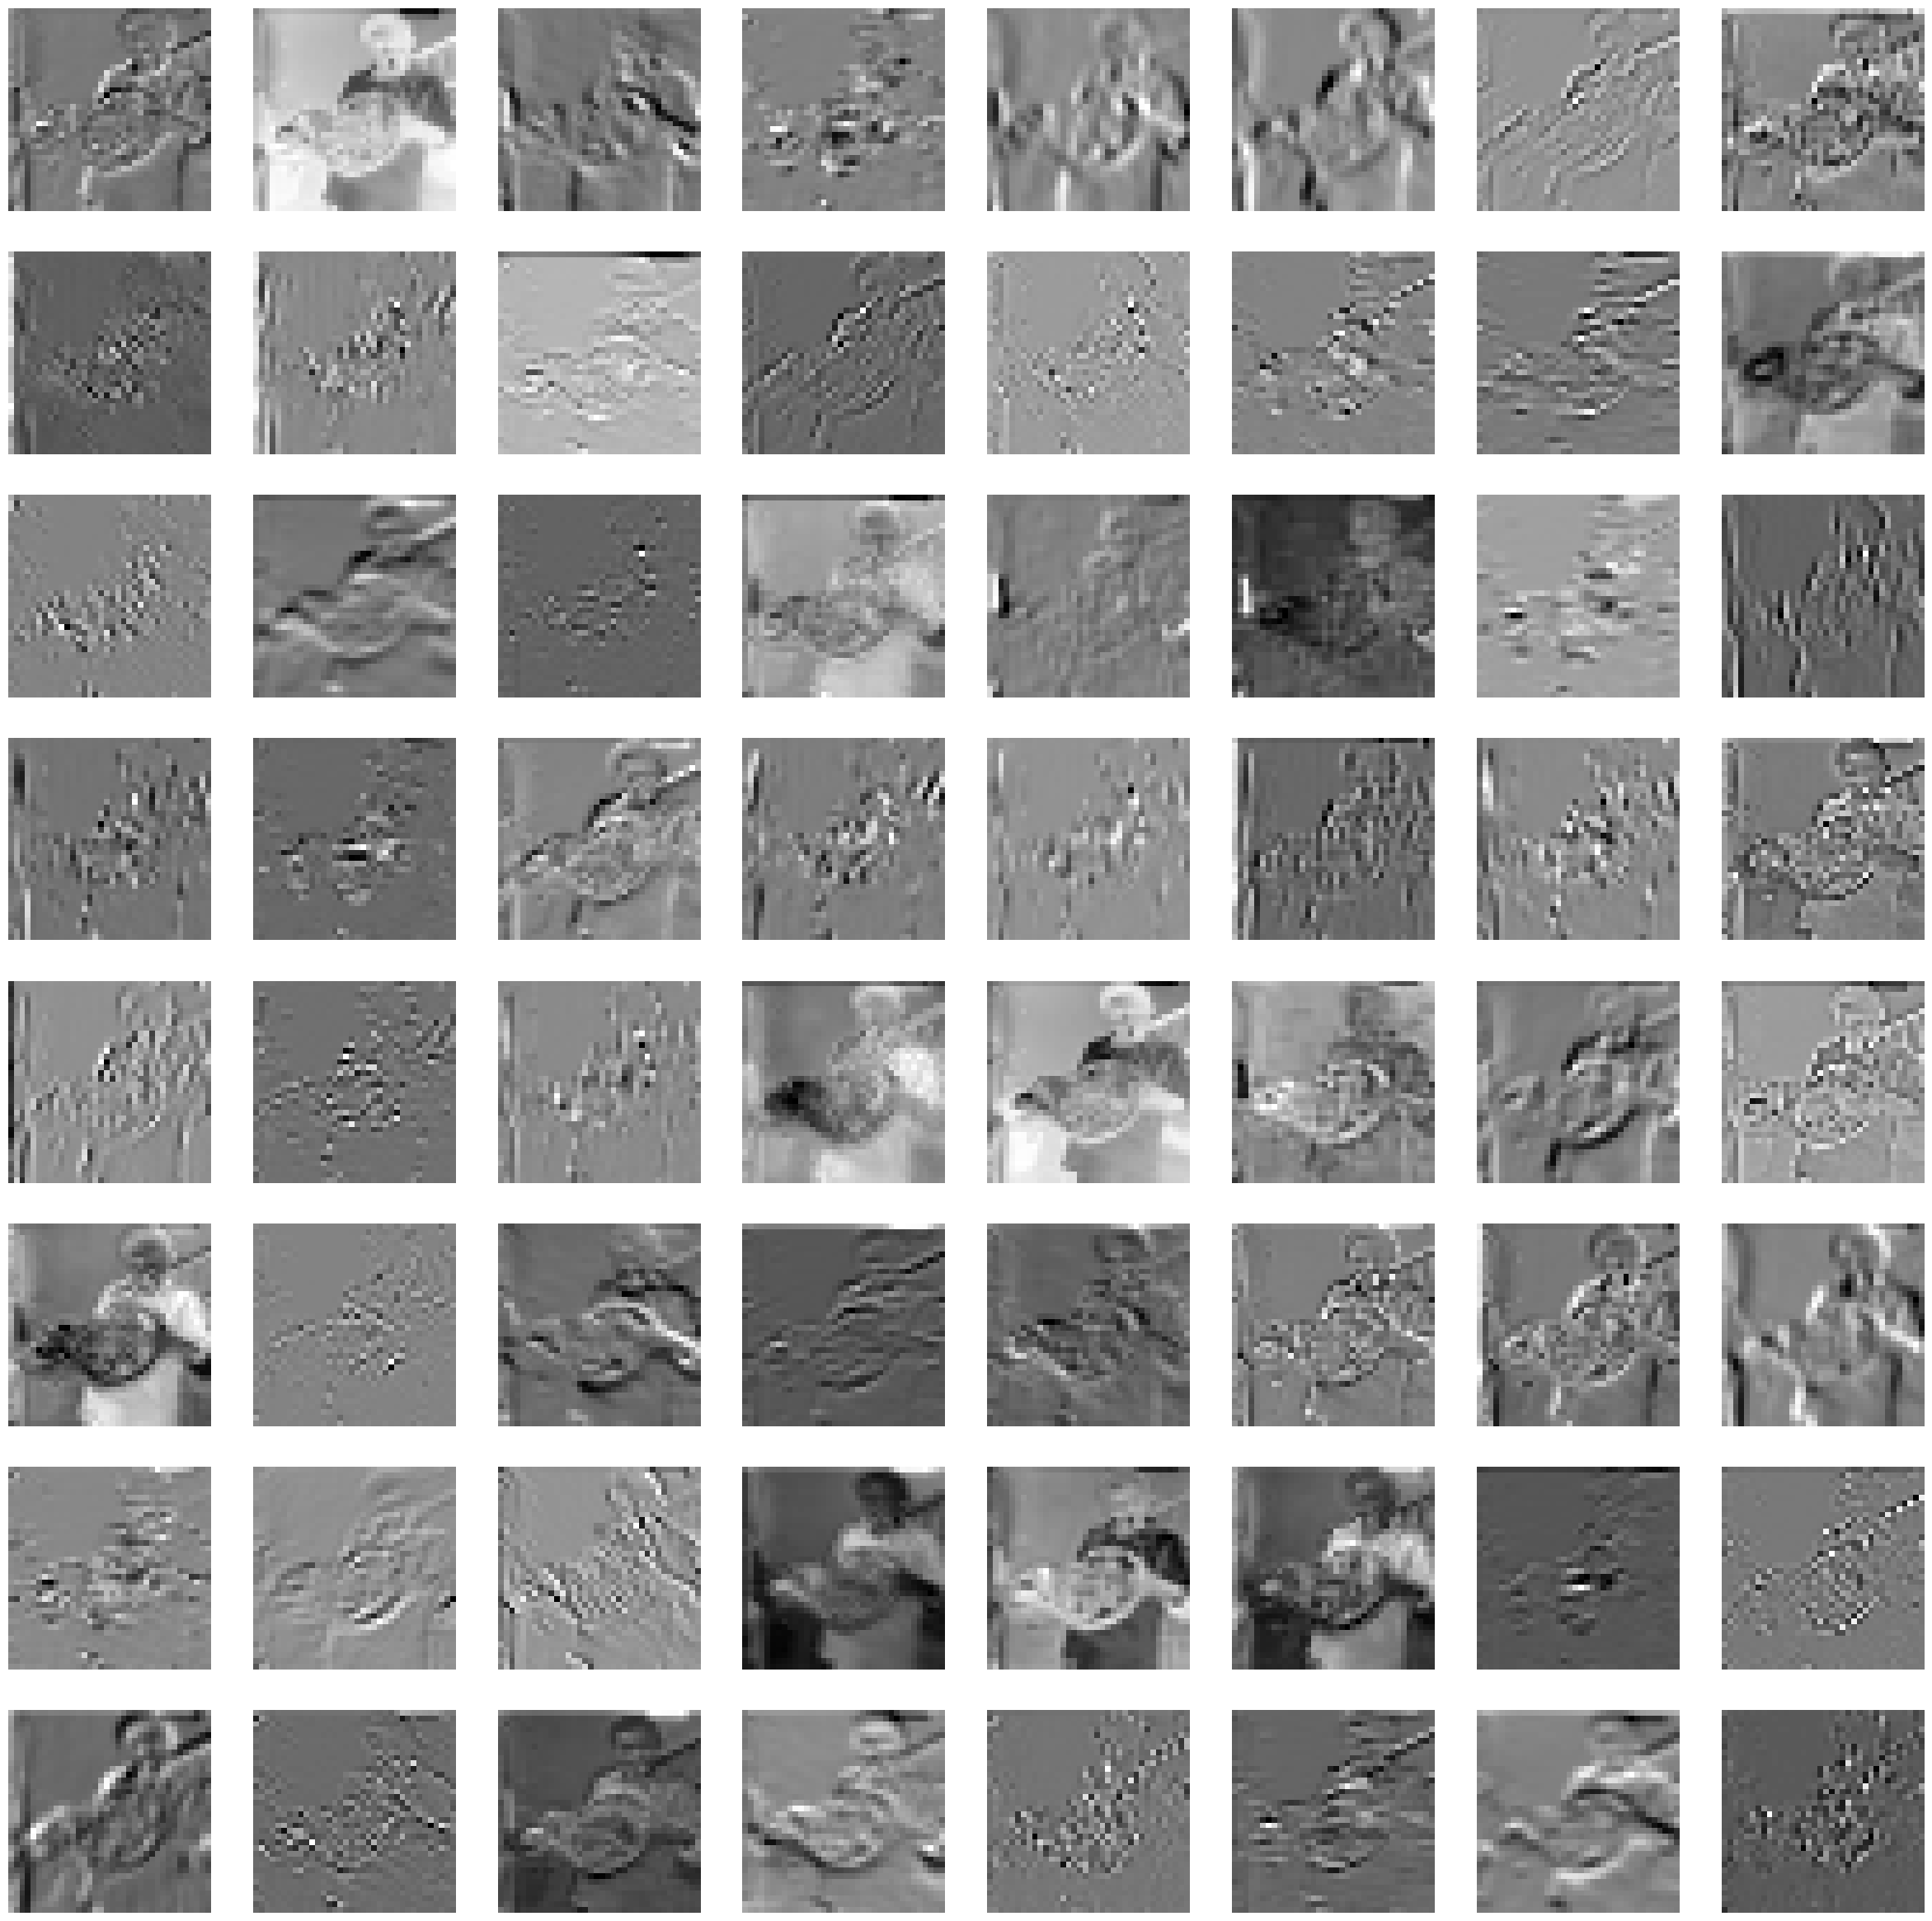

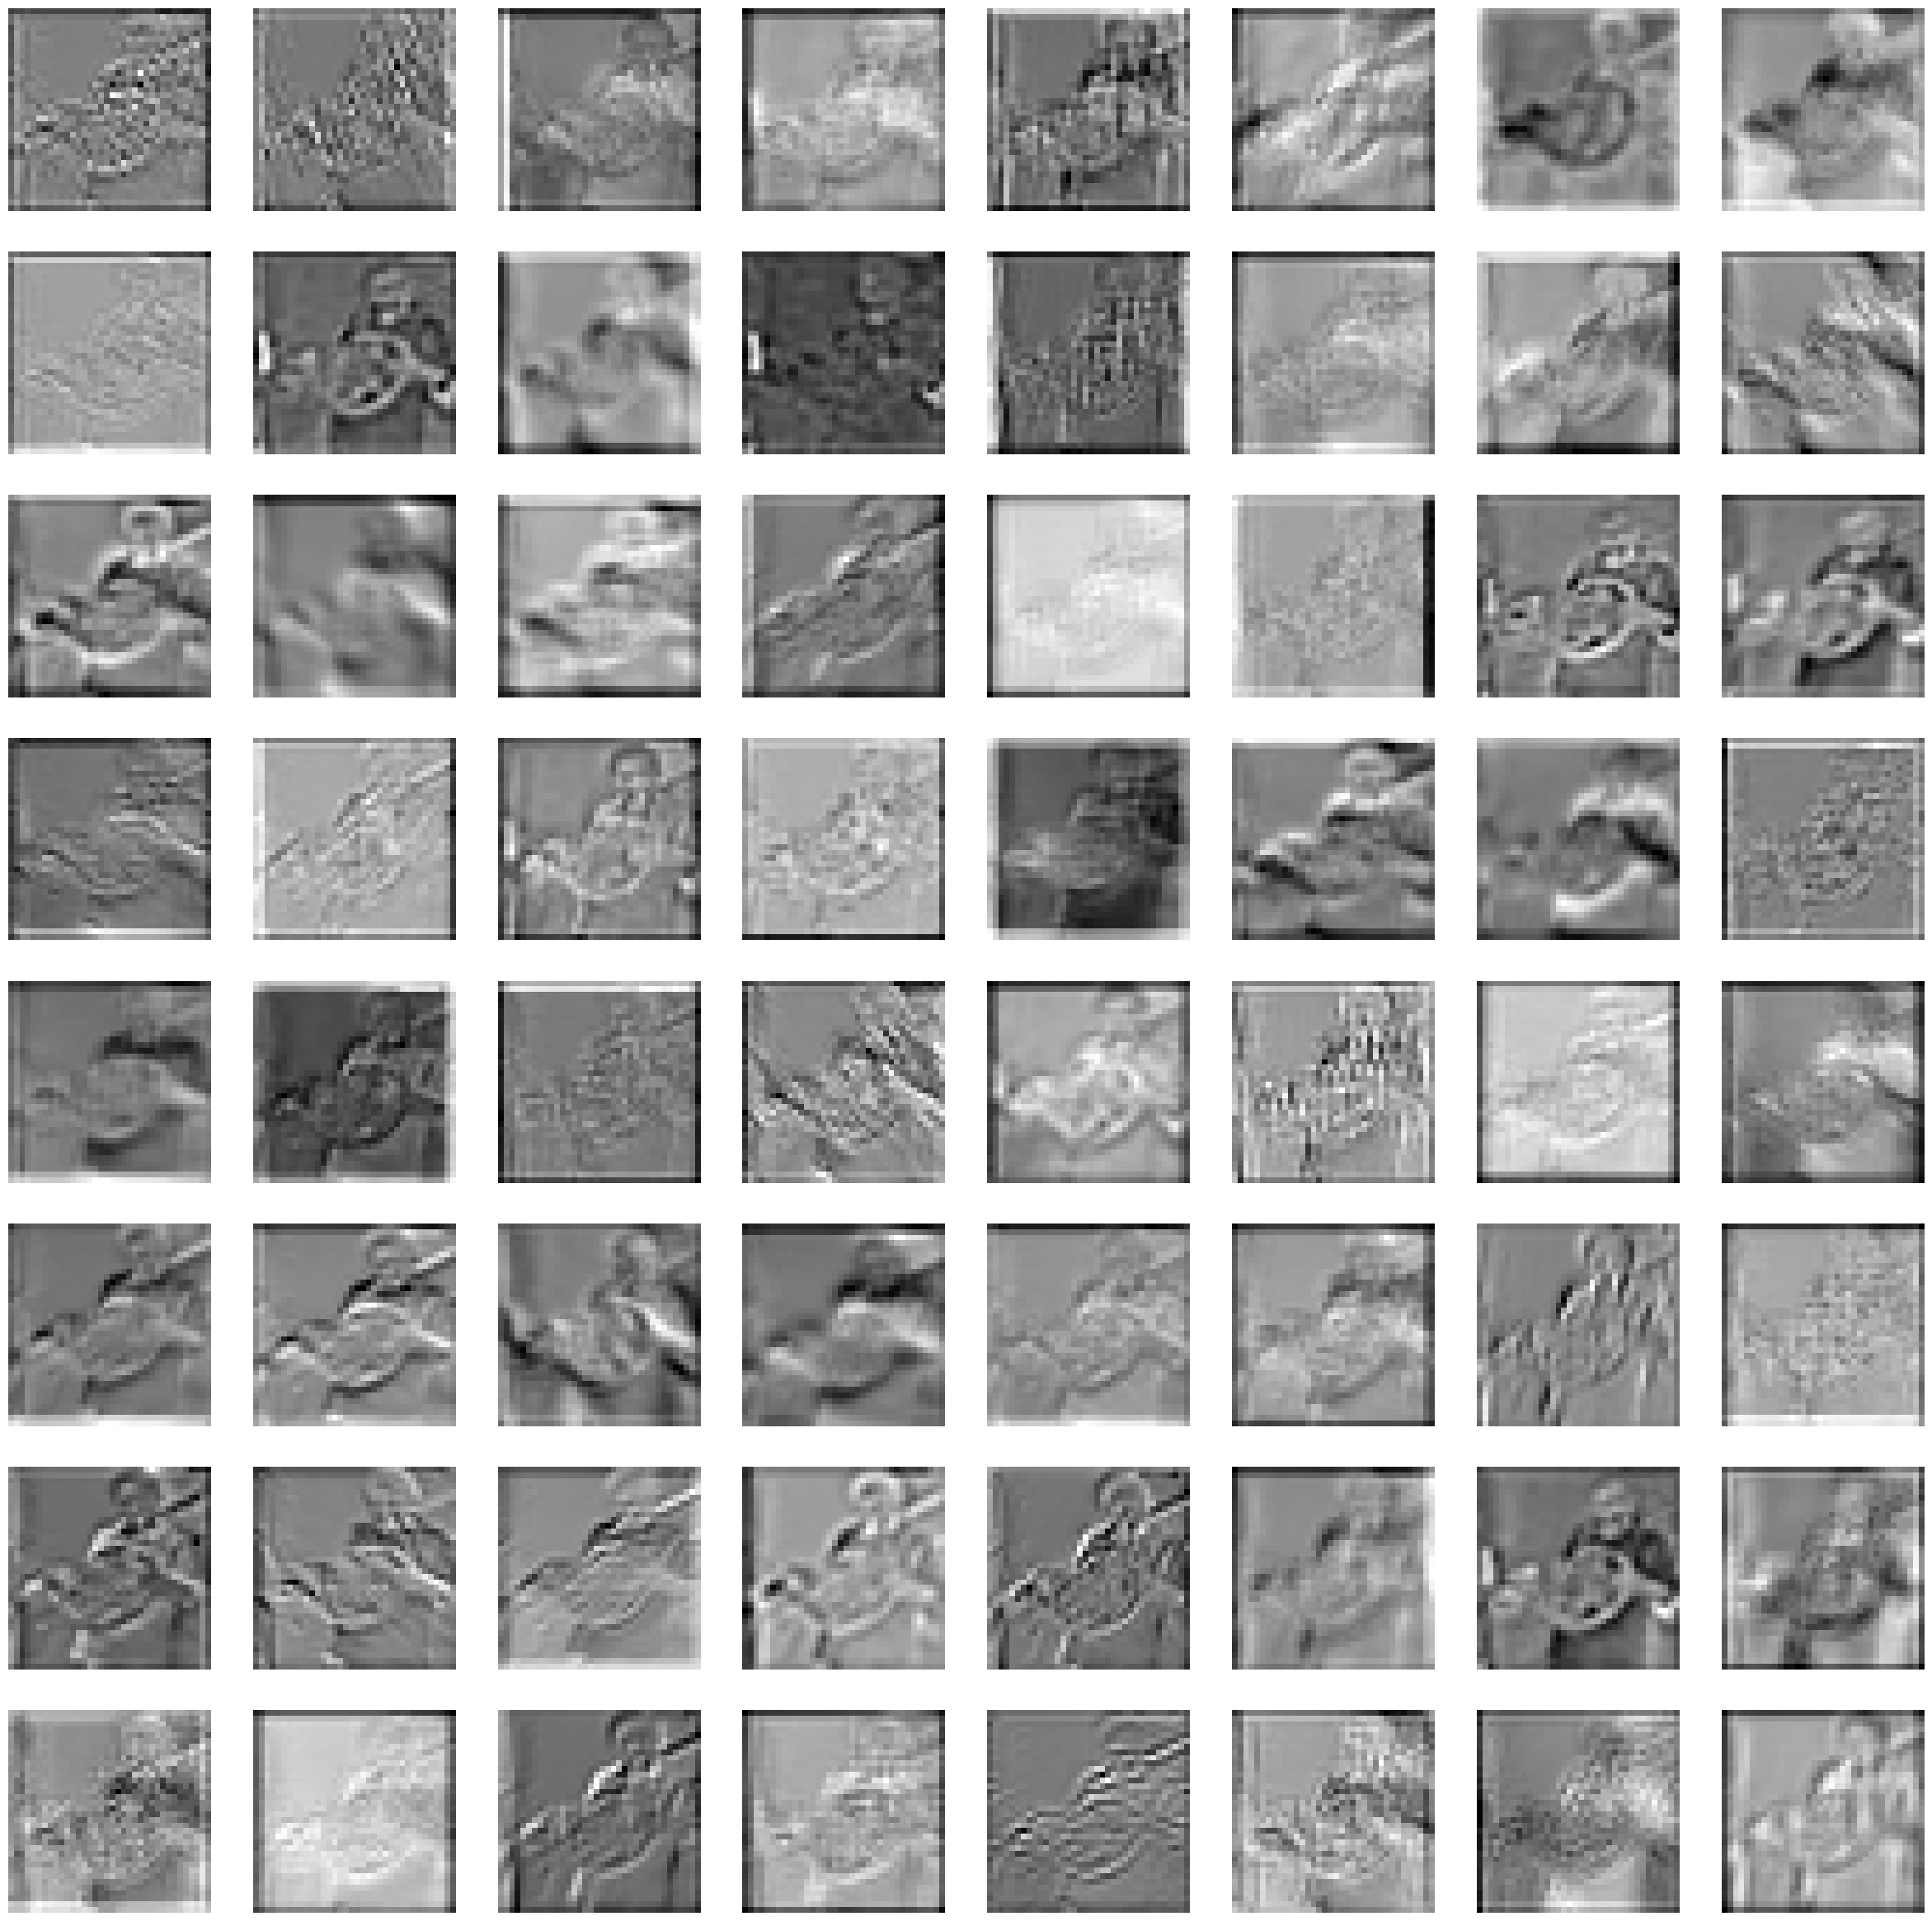

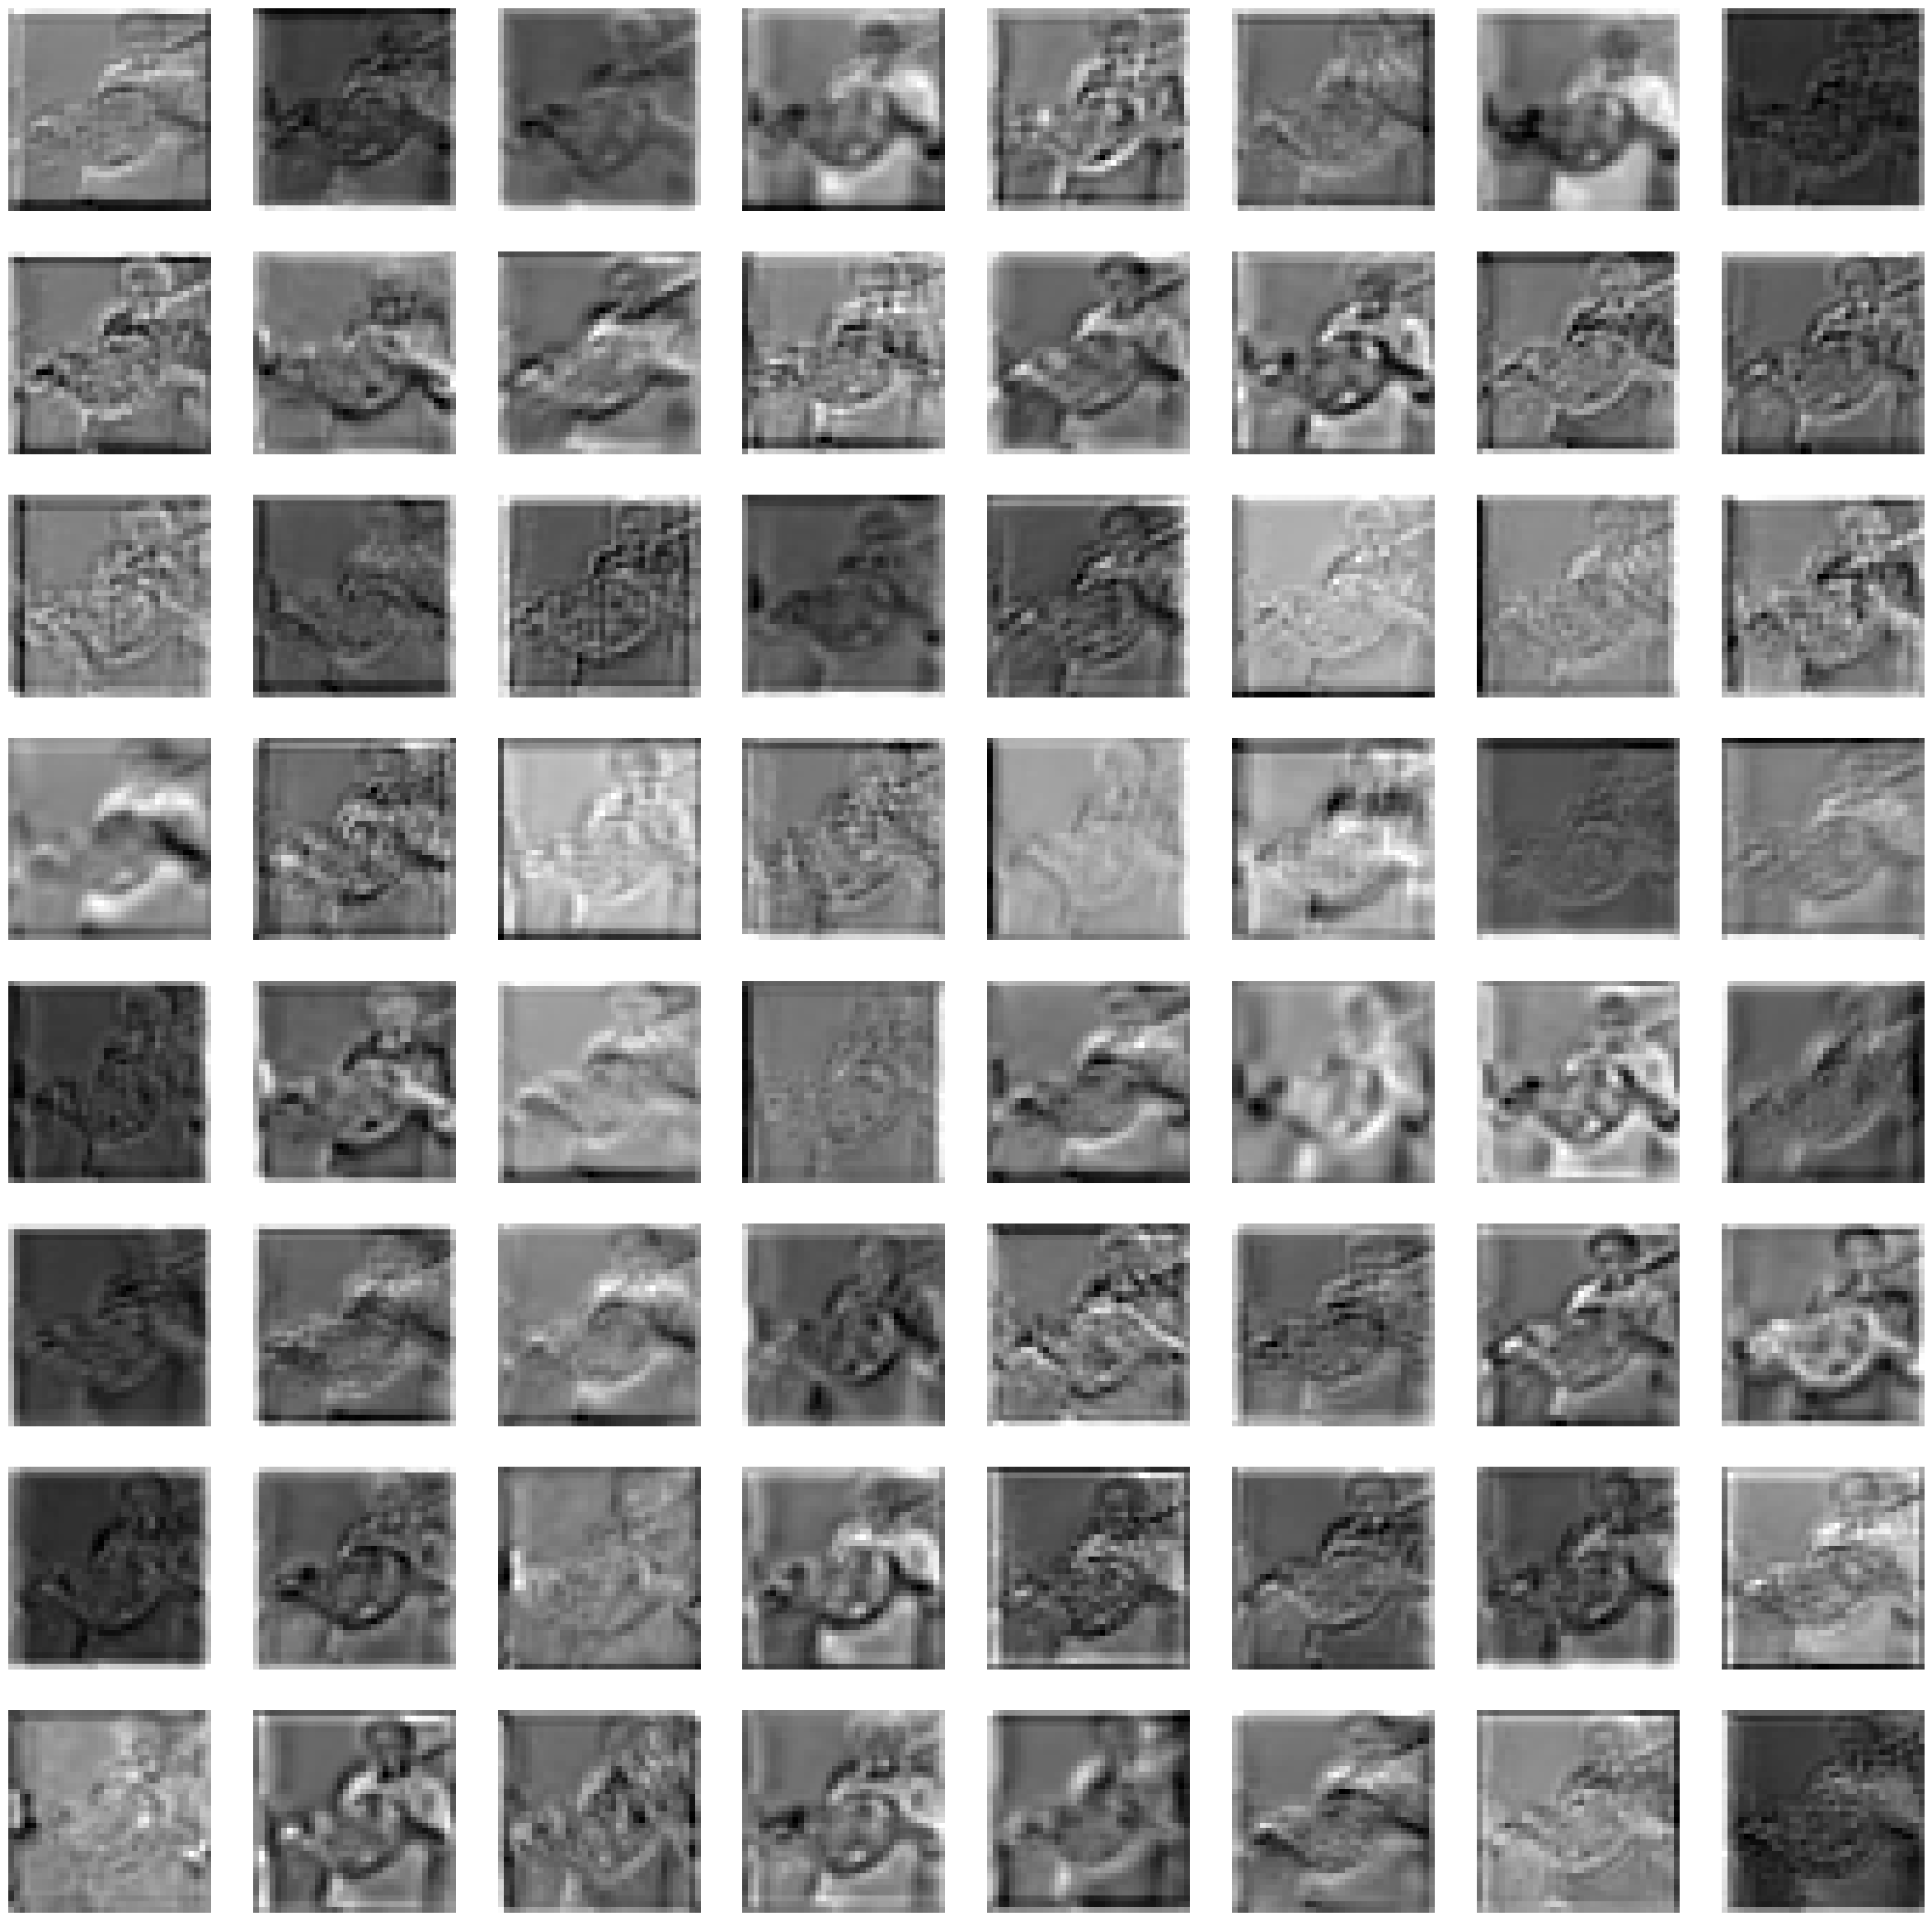

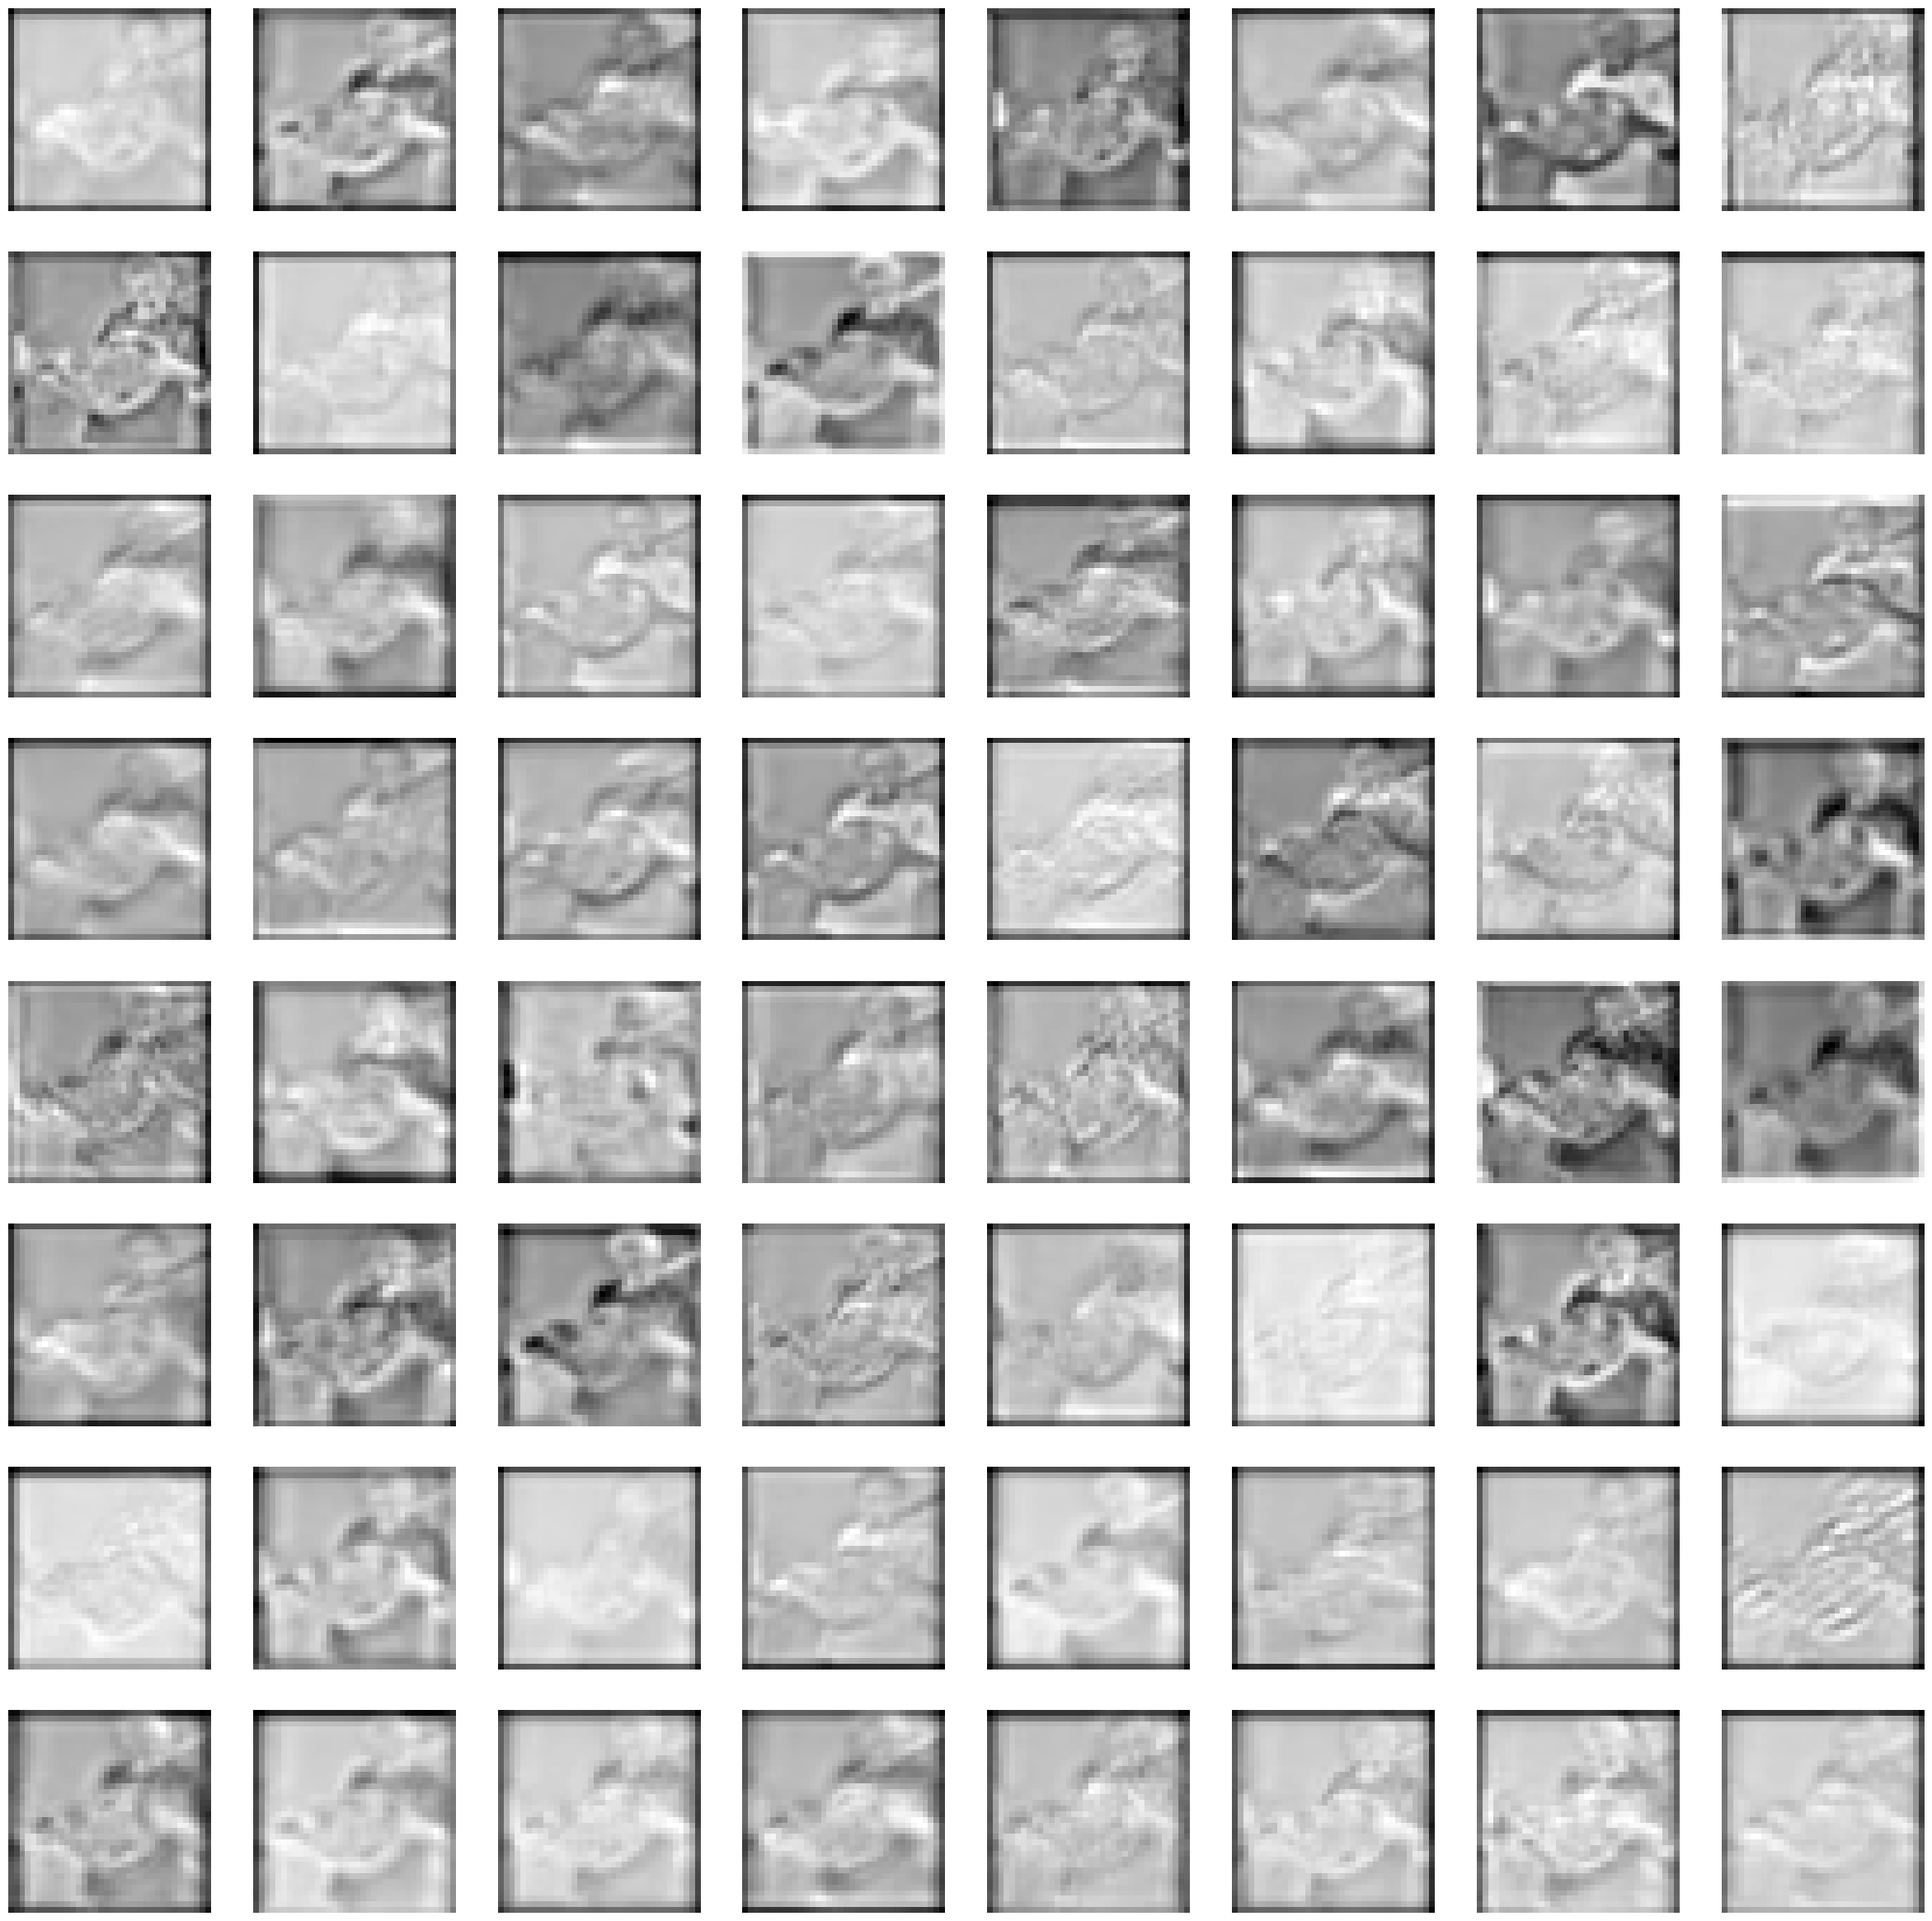

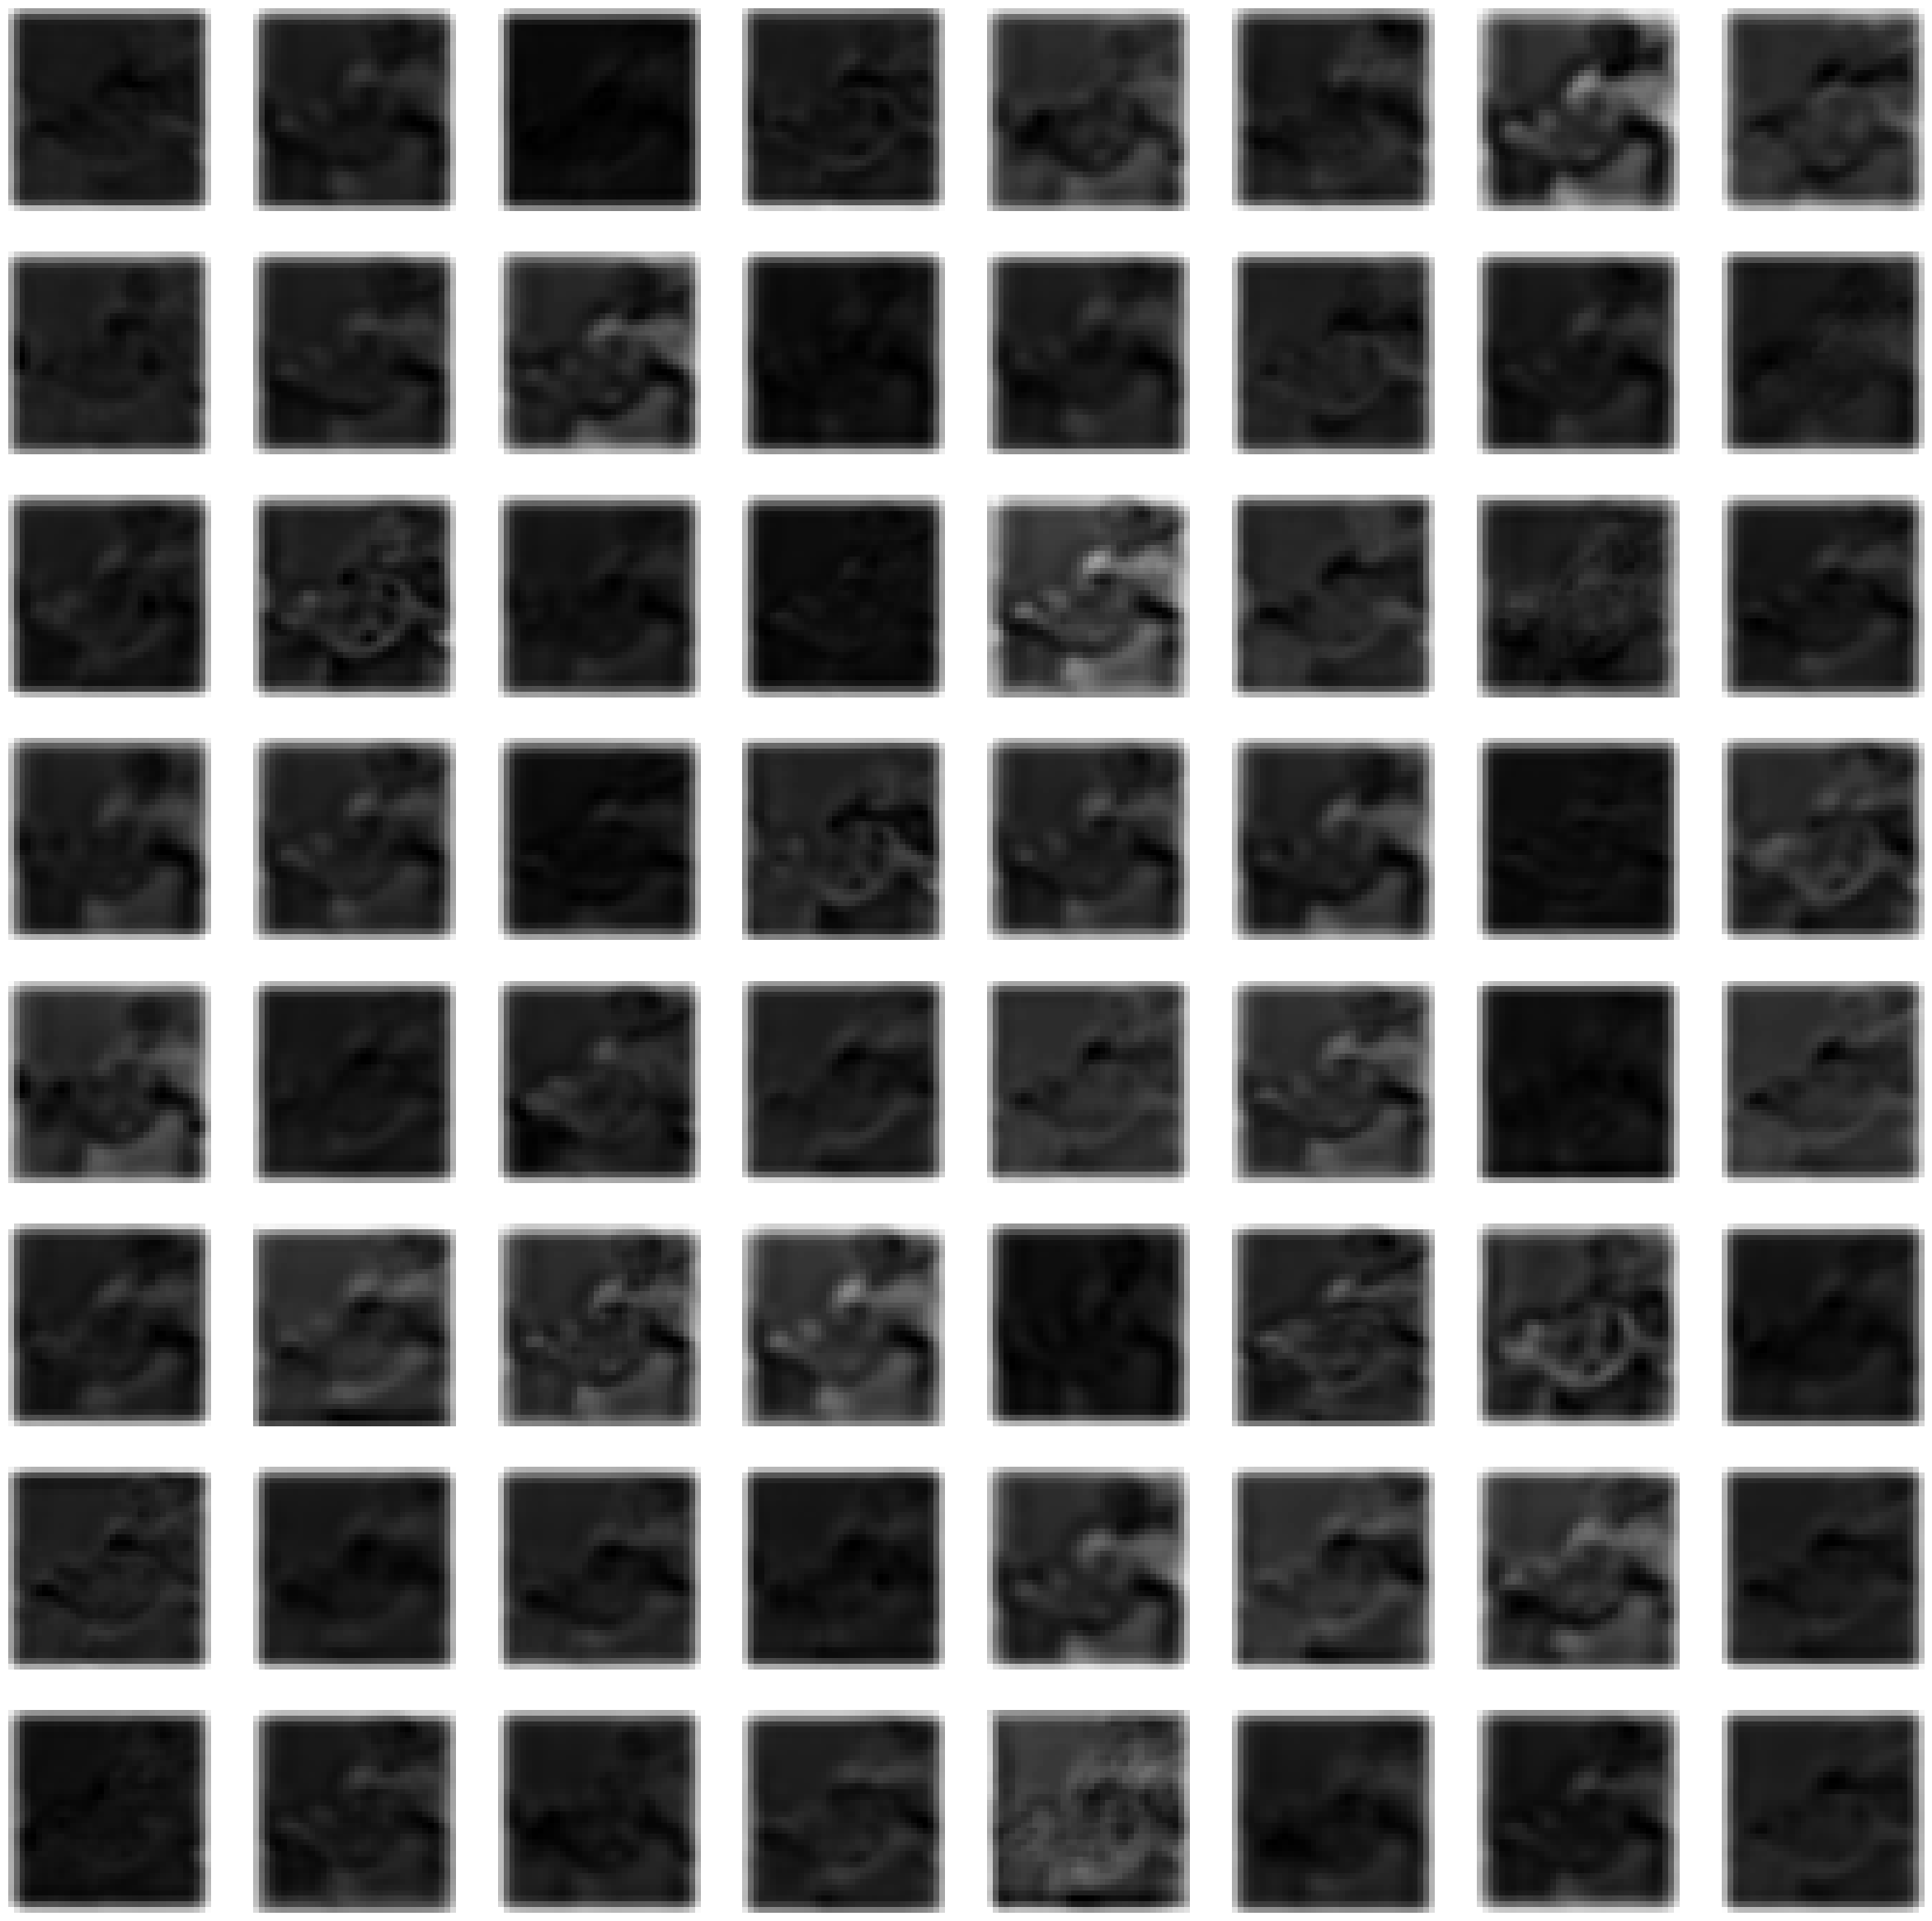

In [16]:
# Kép áteresztése a konvolúciós rétegeken 
results = [conv_layers[0](img)]
for i in range(1, len(conv_layers)):
    results.append(conv_layers[i](results[-1]))
outputs = results

# A jellemzőképek vizualizálása a rétegekhez tartozóan
for num_layer in range(len(outputs)):
    plt.figure(figsize=(30, 30))
    layer_viz = outputs[num_layer][0, :, :, :]
    layer_viz = layer_viz.data
    print(layer_viz.size())
    for i, flt in enumerate(layer_viz):
        if i == 64:
            break
        plt.subplot(8, 8, i + 1)
        plt.imshow(flt, cmap='gray')
        plt.axis("off")